**PREDICTING CREDIT RISK DEFAULTERS**

Problem Statement:
A mid-sized bank aims to identify customers who are likely to default on their loans within the next 6 months. Additionally, the bank wants to segment its customers for targeted marketing. The bank has provided customer data, including loan information, transaction history, and account details.

Name : H John Joshua

Reg No : 2348425

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

Data Loading and Initial Inspection

In [72]:
# Load the data
url = "Data.csv"
df = pd.read_csv(url)

# Display the first few rows and basic information about the dataset
print(df.head())
print("\nDataset Info:")
print(df.info())

   Customer_ID  Age  Gender  Income  Credit_Score  Loan_Amount  Loan_Term  \
0            1   69    Male   37114           678      4905.22         12   
1            2   98    Male  -49215           778      6374.88         12   
2            3   60  Female   34352           696      6622.15         36   
3            4   51    Male  121193           655     25610.96         24   
4            5   46  Female  115249           702     22509.28         72   

   Number_of_Loans  Transaction_Count  Account_Balance Marital_Status  \
0                1                 18          3836.25        married   
1                3                  4          5300.84      unmarried   
2                5                  8          5668.57        married   
3                2                 10          9202.42       divorced   
4                5                 13          8138.34        married   

   Credit_Default_Status    Job  
0                      0  Other  
1                      0  Othe

In [73]:
# Display summary statistics and check for missing values
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

       Customer_ID          Age         Income  Credit_Score   Loan_Amount  \
count  5000.000000  5000.000000    5000.000000   5000.000000   4695.000000   
mean   2500.500000    41.241200   64121.831800    652.243400  16545.320735   
std    1443.520003    15.759629   30845.717505    128.409233   9644.842666   
min       1.000000    18.000000  -88718.000000    300.000000 -12063.540000   
25%    1250.750000    26.000000   40592.000000    612.000000   9566.770000   
50%    2500.500000    41.000000   53917.500000    679.000000  14022.940000   
75%    3750.250000    54.000000   88177.000000    736.000000  21417.675000   
max    5000.000000   103.000000  139870.000000    850.000000  53761.810000   

         Loan_Term  Number_of_Loans  Transaction_Count  Account_Balance  \
count  5000.000000      5000.000000        5000.000000      5000.000000   
mean     42.028800         3.010000          11.182800      7136.766706   
std      20.423188         1.428954           7.319378      5016.282889 

Dataset contains 13 columns and 5000 rows.

Missing values are observed in Gender, Loan_Amount, and Marital_Status.

Negative values in Income column indicate potential data entry errors.

Data Cleaning

In [74]:
# Handle missing values
df['Gender'].fillna('Unknown', inplace=True)
df['Marital_Status'].fillna('Unknown', inplace=True)
df['Loan_Amount'].fillna(df['Loan_Amount'].median(), inplace=True)

# Handle negative income values
df.loc[df['Income'] < 0, 'Income'] = df[df['Income'] > 0]['Income'].median()

# Display summary statistics
print(df.describe())

# Check for any remaining missing values
print("\nMissing values:")
print(df.isnull().sum())

       Customer_ID          Age         Income  Credit_Score   Loan_Amount  \
count  5000.000000  5000.000000    5000.000000   5000.000000   5000.000000   
mean   2500.500000    41.241200   64424.015000    652.243400  16391.455510   
std    1443.520003    15.759629   30203.608088    128.409233   9365.466226   
min       1.000000    18.000000       0.000000    300.000000 -12063.540000   
25%    1250.750000    26.000000   40742.250000    612.000000   9822.477500   
50%    2500.500000    41.000000   54062.500000    679.000000  14022.940000   
75%    3750.250000    54.000000   88177.000000    736.000000  20724.030000   
max    5000.000000   103.000000  139870.000000    850.000000  53761.810000   

         Loan_Term  Number_of_Loans  Transaction_Count  Account_Balance  \
count  5000.000000      5000.000000        5000.000000      5000.000000   
mean     42.028800         3.010000          11.182800      7136.766706   
std      20.423188         1.428954           7.319378      5016.282889 

All missing values are handled appropriately.

The cleaned dataset is ready for analysis with no null values.

Data Exploration and Summary Statistics

In [75]:
# Display unique values in categorical columns
categorical_cols = ['Gender', 'Marital_Status', 'Job']
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())

# Display the distribution of the target variable
print("\nCredit Default Status Distribution:")
print(df['Credit_Default_Status'].value_counts(normalize=True))


Unique values in Gender:
Gender
Male       2431
Female     2297
Unknown     272
Name: count, dtype: int64

Unique values in Marital_Status:
Marital_Status
unmarried      1744
divorced       1020
married         993
not married     945
Unknown         298
Name: count, dtype: int64

Unique values in Job:
Job
Other              3488
Entry-Level         589
IT Professional     480
Skilled Worker      353
Executive            54
Managerial           36
Name: count, dtype: int64

Credit Default Status Distribution:
Credit_Default_Status
0    0.78
1    0.22
Name: proportion, dtype: float64


The average income is around 64,424, with a wide range from 0 to 139,870.

The Credit_Default_Status variable indicates 22% defaulters.


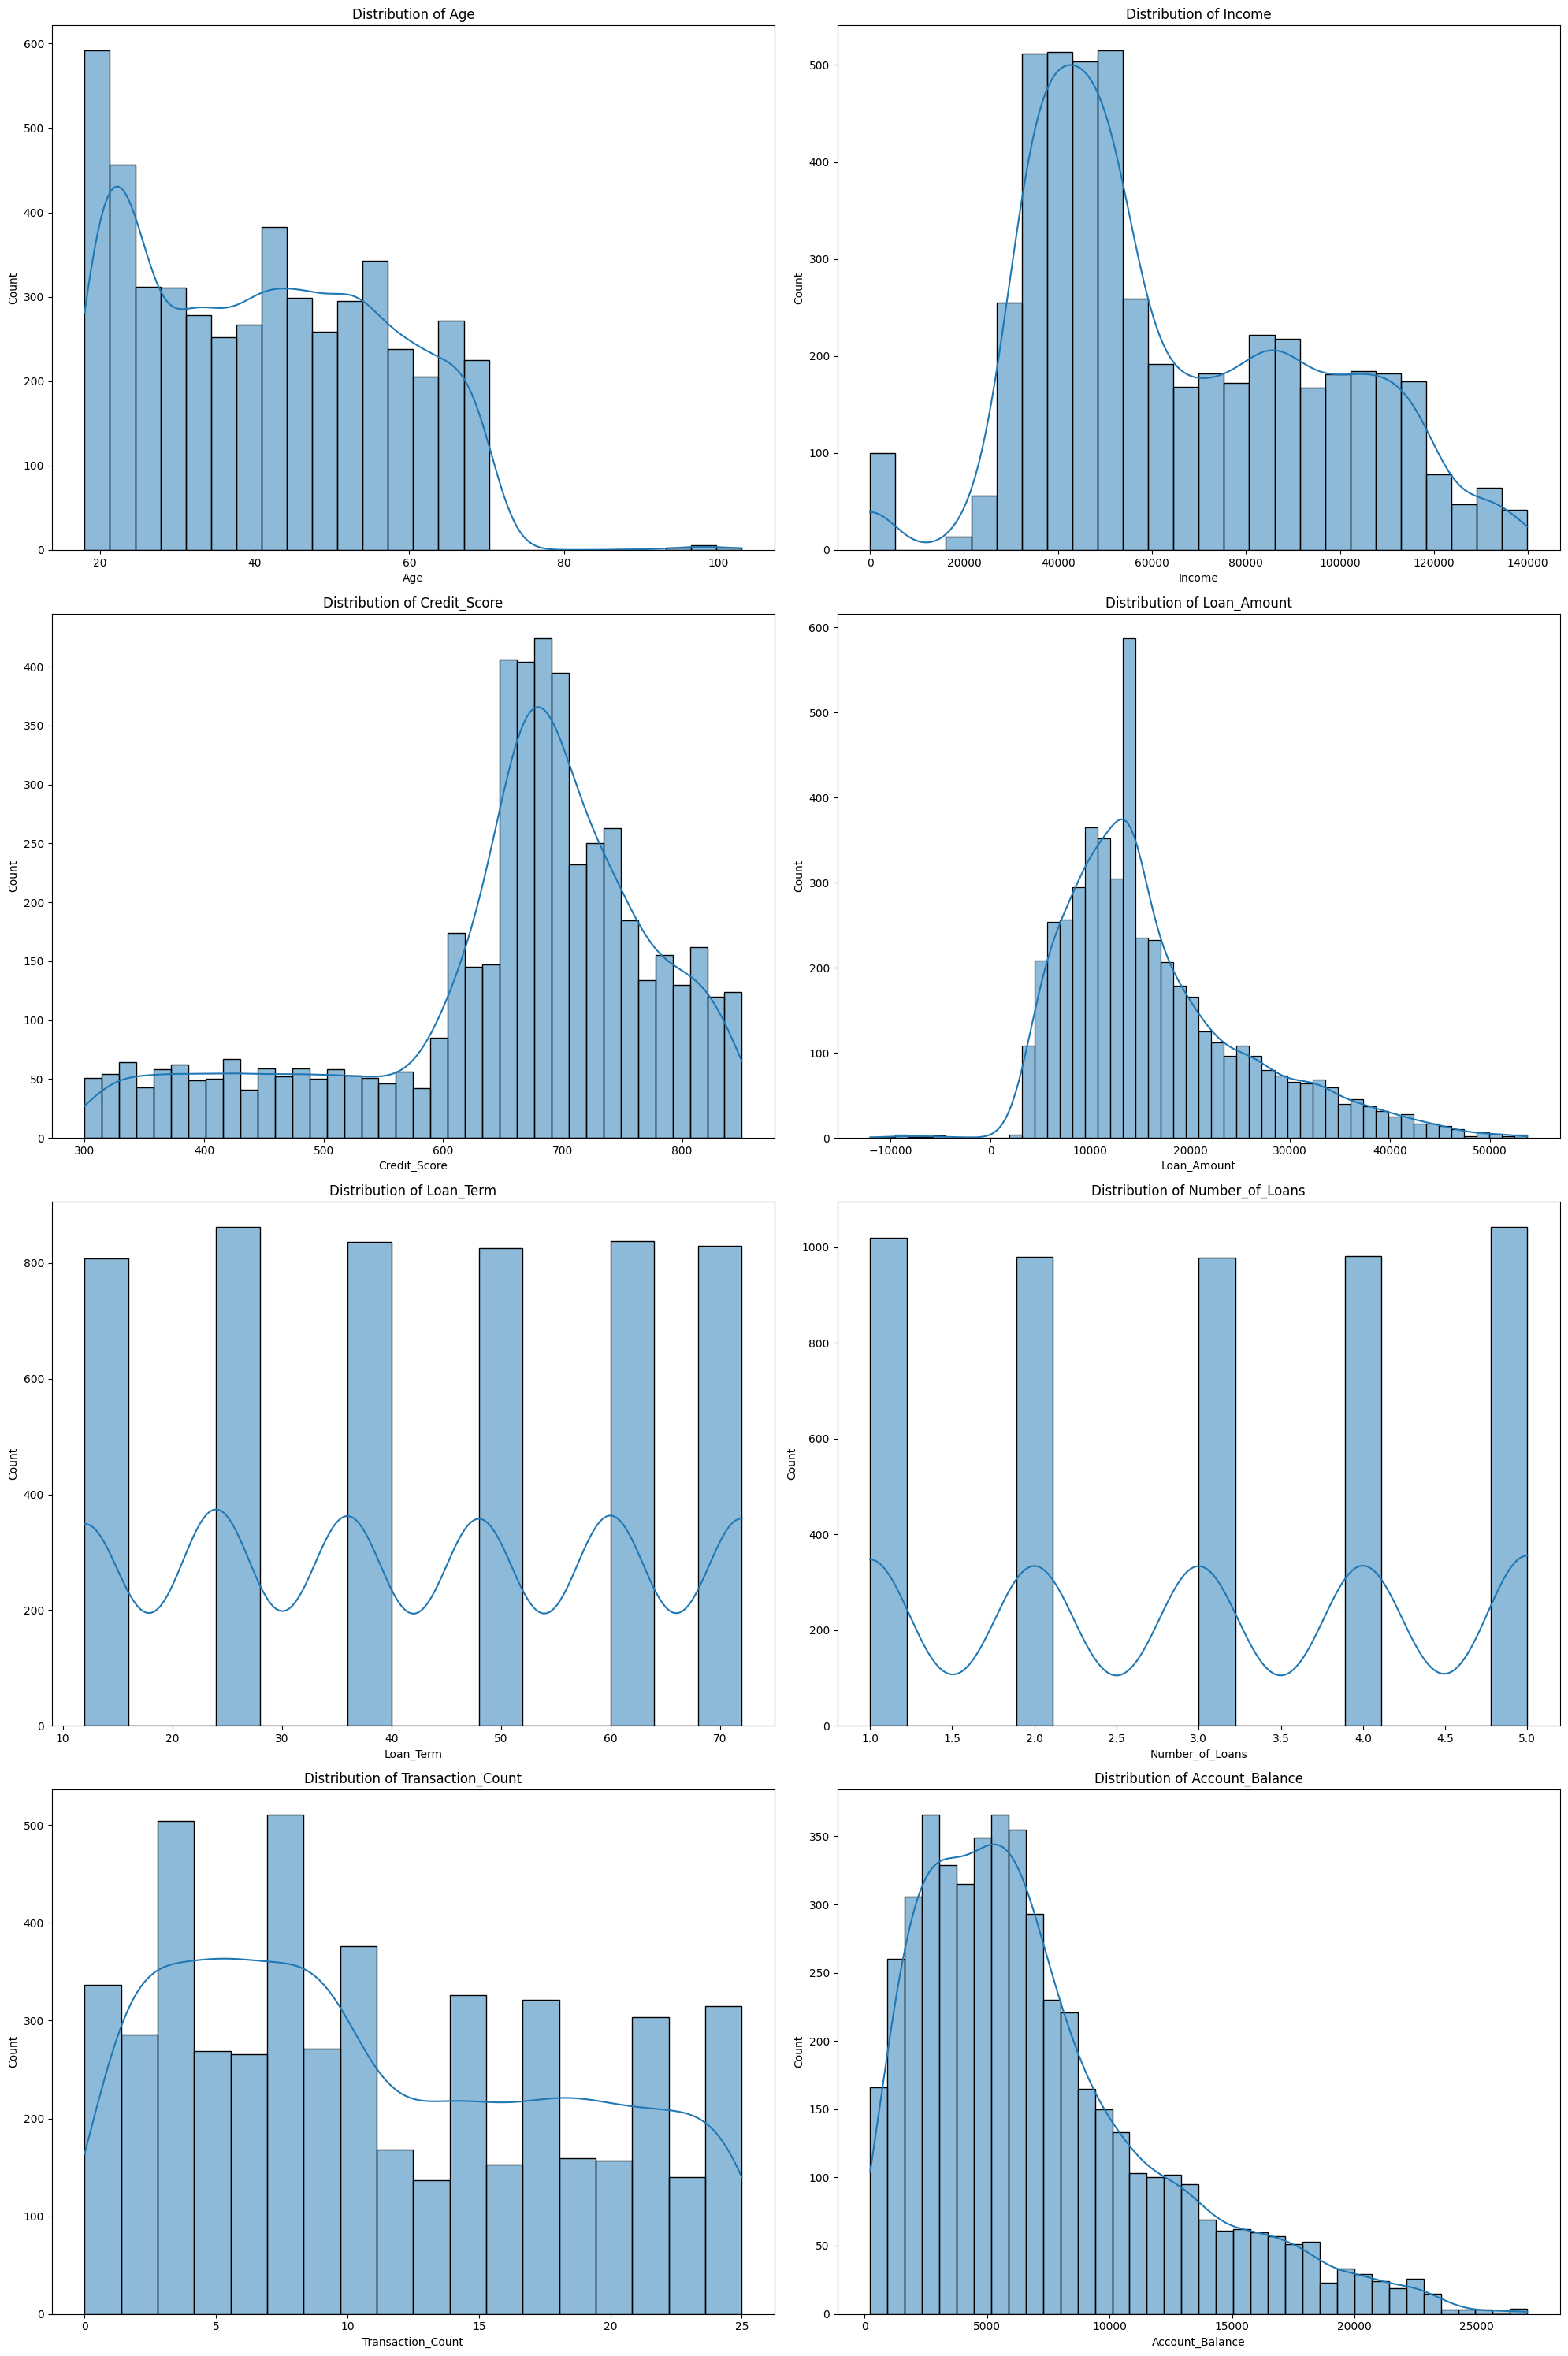

In [76]:
# Visualize the distribution of numerical variables
numerical_cols = ['Age', 'Income', 'Credit_Score', 'Loan_Amount', 'Loan_Term', 'Number_of_Loans', 'Transaction_Count', 'Account_Balance']
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Visualizations show skewed distributions in some features, e.g., Account_Balance.

 Customer Demographics Analysis

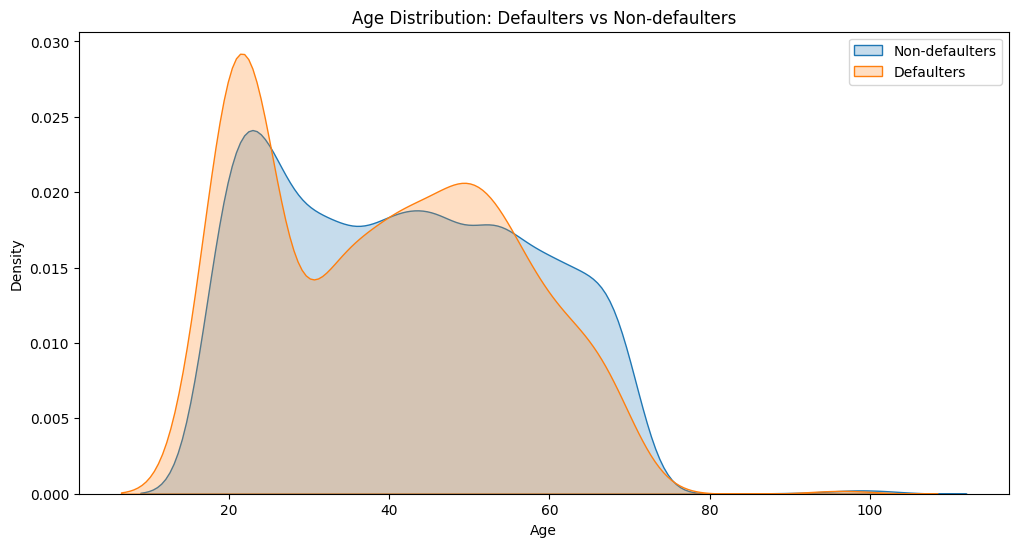

In [77]:
# Age distribution for defaulters vs non-defaulters
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['Credit_Default_Status'] == 0]['Age'], label='Non-defaulters', shade=True)
sns.kdeplot(data=df[df['Credit_Default_Status'] == 1]['Age'], label='Defaulters', shade=True)
plt.title('Age Distribution: Defaulters vs Non-defaulters')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

Younger customers (18–25) have higher default probabilities.

Older customers (above 50) tend to have fewer defaults.

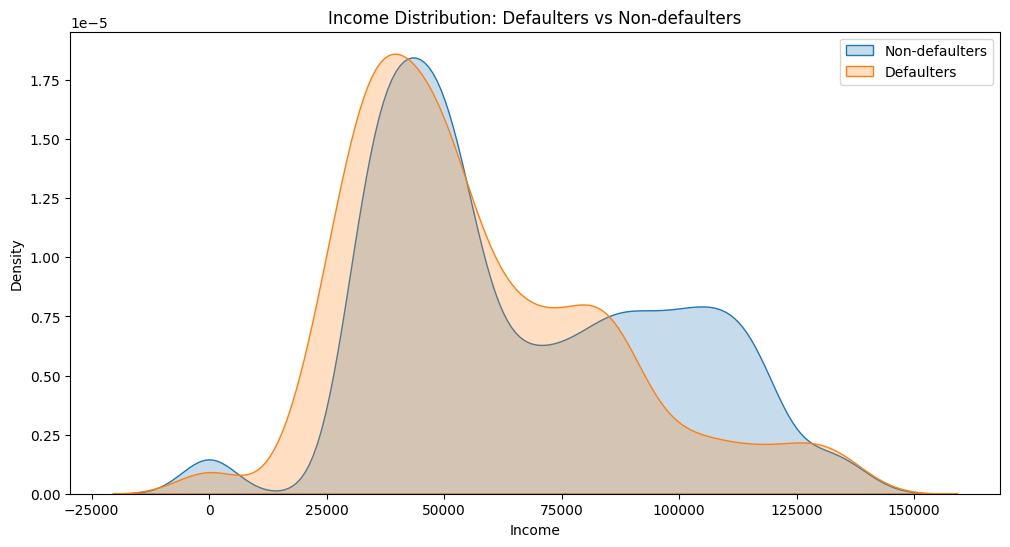

In [78]:
# Income distribution for defaulters vs non-defaulters
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['Credit_Default_Status'] == 0]['Income'], label='Non-defaulters', shade=True)
sns.kdeplot(data=df[df['Credit_Default_Status'] == 1]['Income'], label='Defaulters', shade=True)
plt.title('Income Distribution: Defaulters vs Non-defaulters')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.show()

Lower income correlates with higher default rates.

High-income customers are less likely to default.

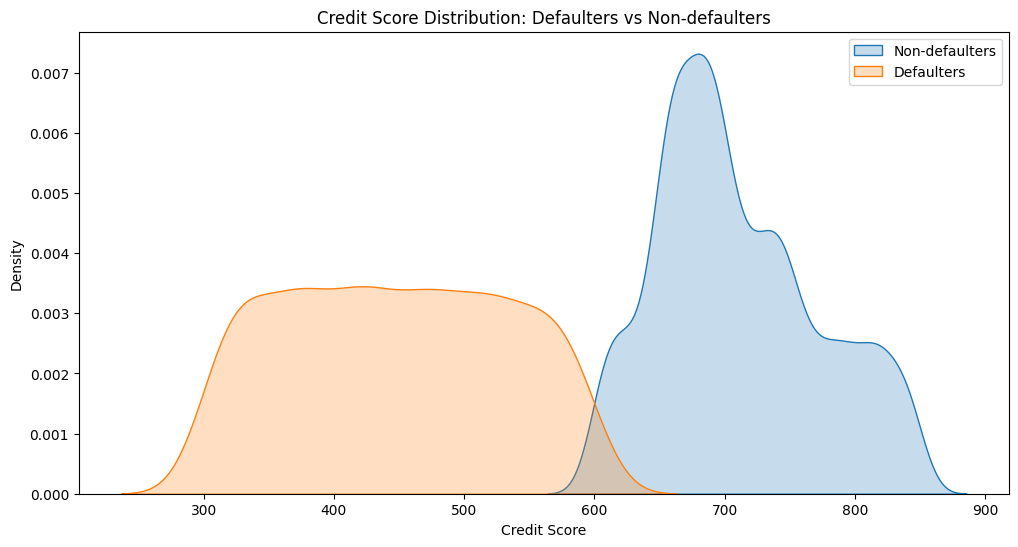

In [79]:
# Credit Score distribution for defaulters vs non-defaulters
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df[df['Credit_Default_Status'] == 0]['Credit_Score'], label='Non-defaulters', shade=True)
sns.kdeplot(data=df[df['Credit_Default_Status'] == 1]['Credit_Score'], label='Defaulters', shade=True)
plt.title('Credit Score Distribution: Defaulters vs Non-defaulters')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.legend()
plt.show()



Defaulters have lower average credit scores.

Credit scores above 700 are associated with significantly lower defaults.

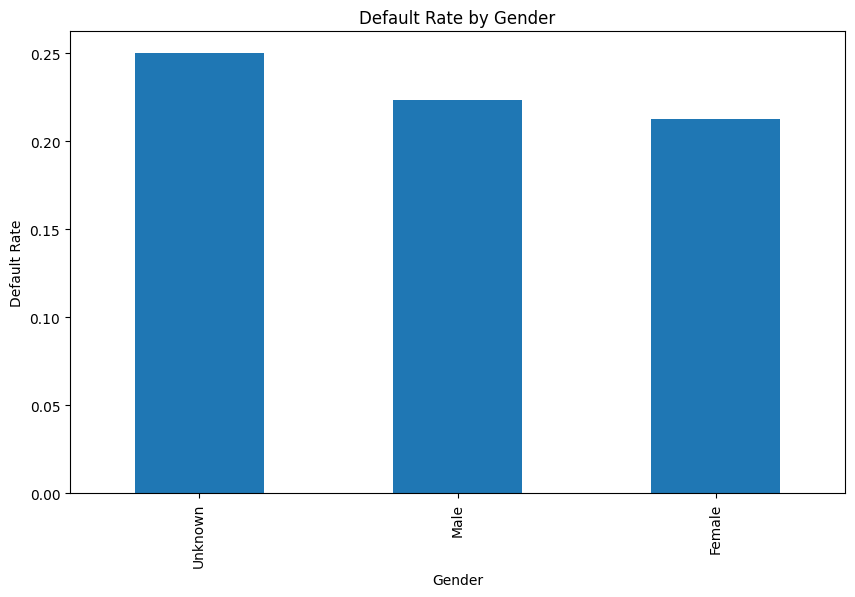

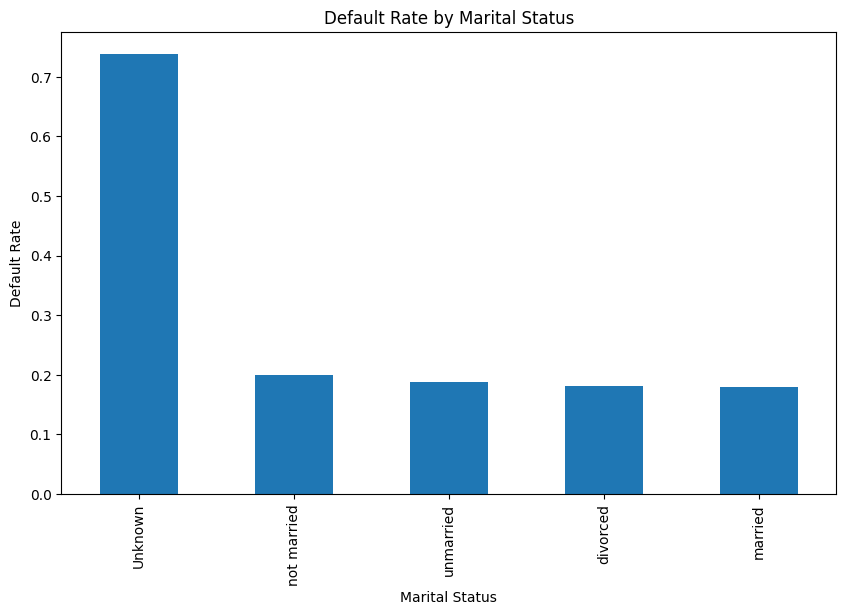

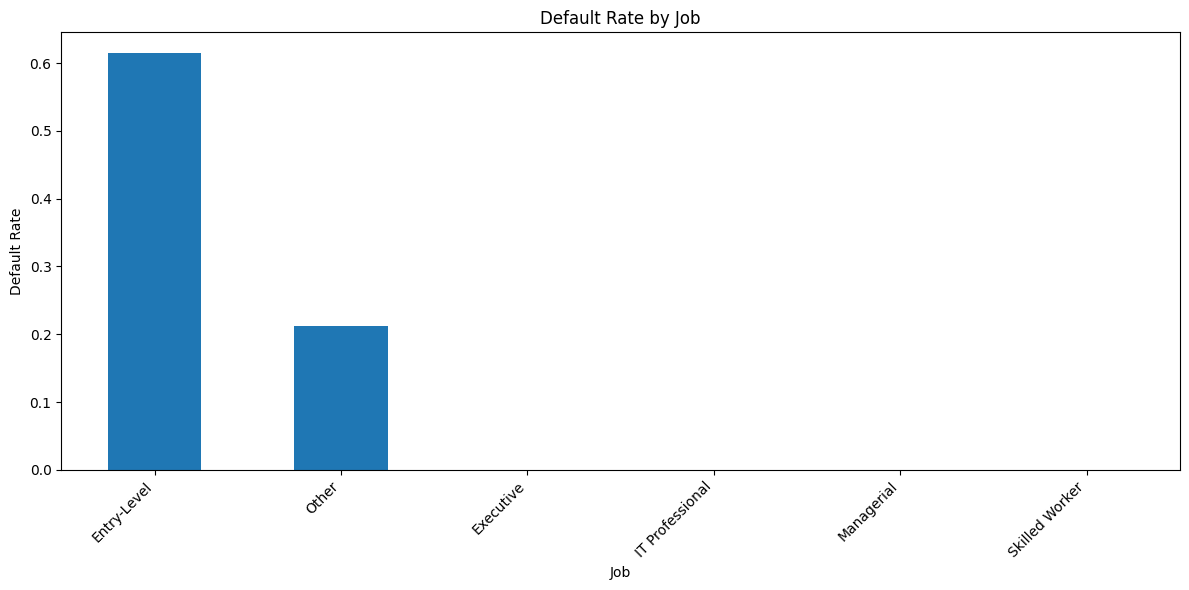

In [80]:
# Default rates by gender
gender_default = df.groupby('Gender')['Credit_Default_Status'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
gender_default.plot(kind='bar')
plt.title('Default Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Default Rate')
plt.show()

# Default rates by marital status
marital_default = df.groupby('Marital_Status')['Credit_Default_Status'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
marital_default.plot(kind='bar')
plt.title('Default Rate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Default Rate')
plt.show()

# Default rates by job
job_default = df.groupby('Job')['Credit_Default_Status'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
job_default.plot(kind='bar')
plt.title('Default Rate by Job')
plt.xlabel('Job')
plt.ylabel('Default Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Average Loan Amount and Term for Defaulters vs Non-defaulters:
                        Loan_Amount  Loan_Term
Credit_Default_Status                         
0                      16965.369321  42.018462
1                      14356.670182  42.065455


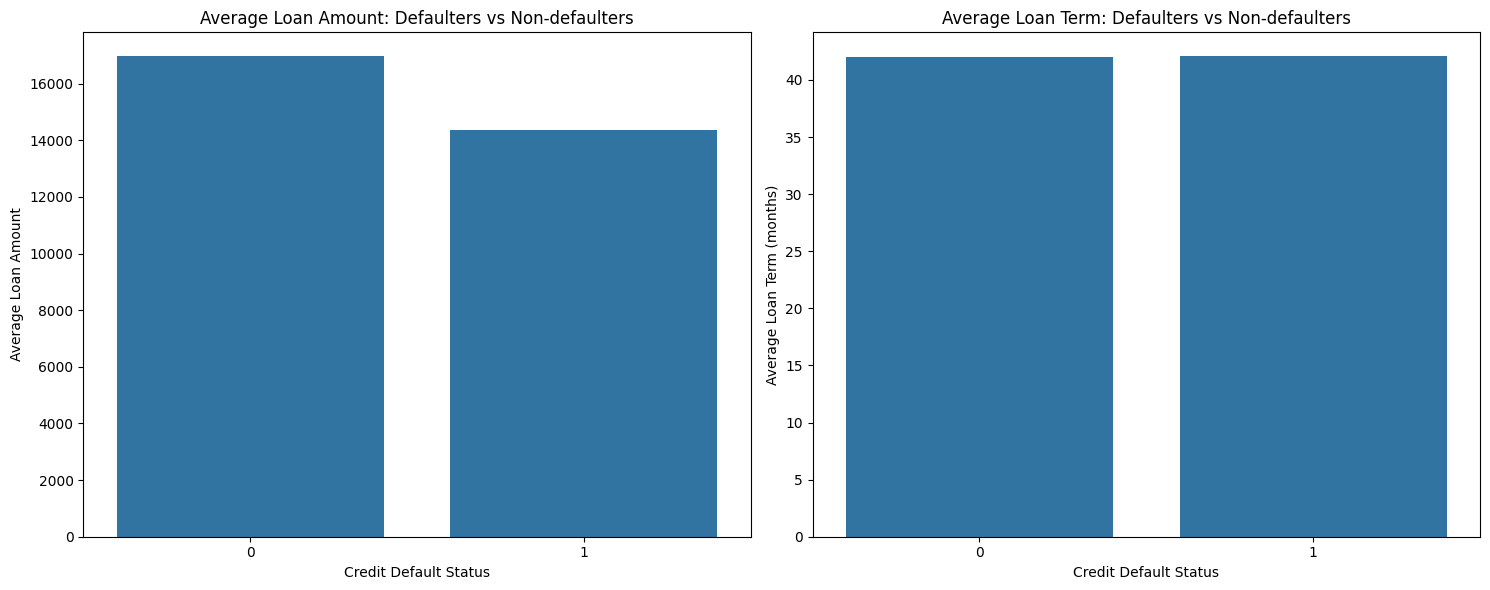

In [81]:
# Average loan amount and term for defaulters vs non-defaulters
loan_stats = df.groupby('Credit_Default_Status')[['Loan_Amount', 'Loan_Term']].mean()
print("Average Loan Amount and Term for Defaulters vs Non-defaulters:")
print(loan_stats)

# Visualize loan amount and term differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(x=loan_stats.index, y=loan_stats['Loan_Amount'], ax=ax1)
ax1.set_title('Average Loan Amount: Defaulters vs Non-defaulters')
ax1.set_xlabel('Credit Default Status')
ax1.set_ylabel('Average Loan Amount')

sns.barplot(x=loan_stats.index, y=loan_stats['Loan_Term'], ax=ax2)
ax2.set_title('Average Loan Term: Defaulters vs Non-defaulters')
ax2.set_xlabel('Credit Default Status')
ax2.set_ylabel('Average Loan Term (months)')

plt.tight_layout()
plt.show()

Transaction and Balance Analysis

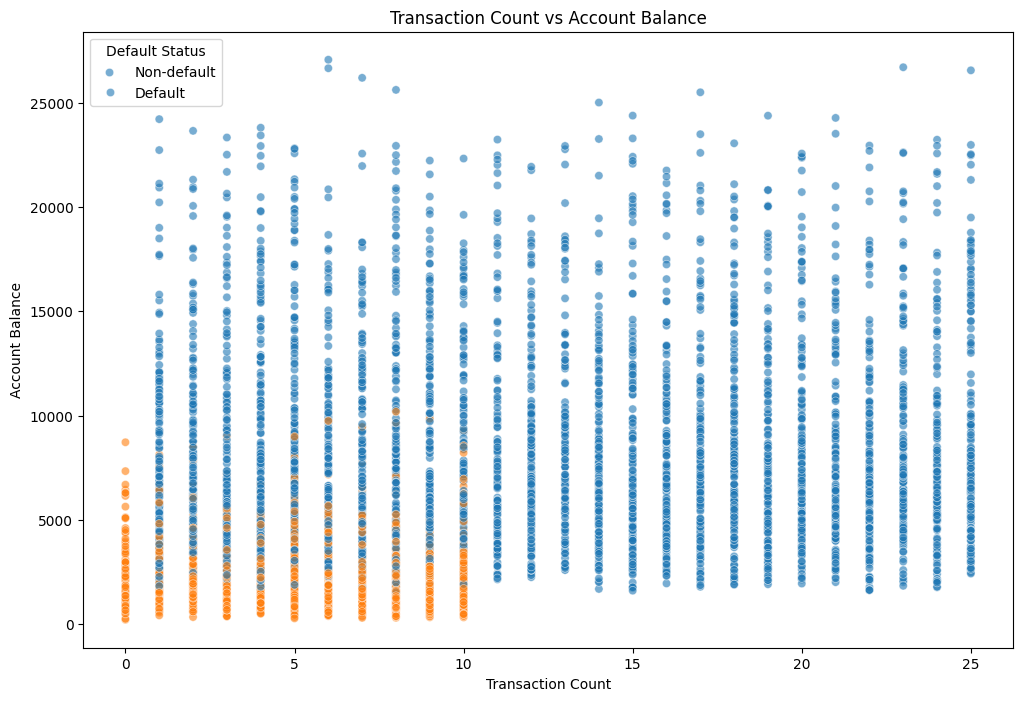

In [82]:
# Scatter plot of Transaction Count vs Account Balance, colored by default status
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Transaction_Count', y='Account_Balance', hue='Credit_Default_Status', alpha=0.6)
plt.title('Transaction Count vs Account Balance')
plt.xlabel('Transaction Count')
plt.ylabel('Account Balance')
plt.legend(title='Default Status', labels=['Non-default', 'Default'])
plt.show()


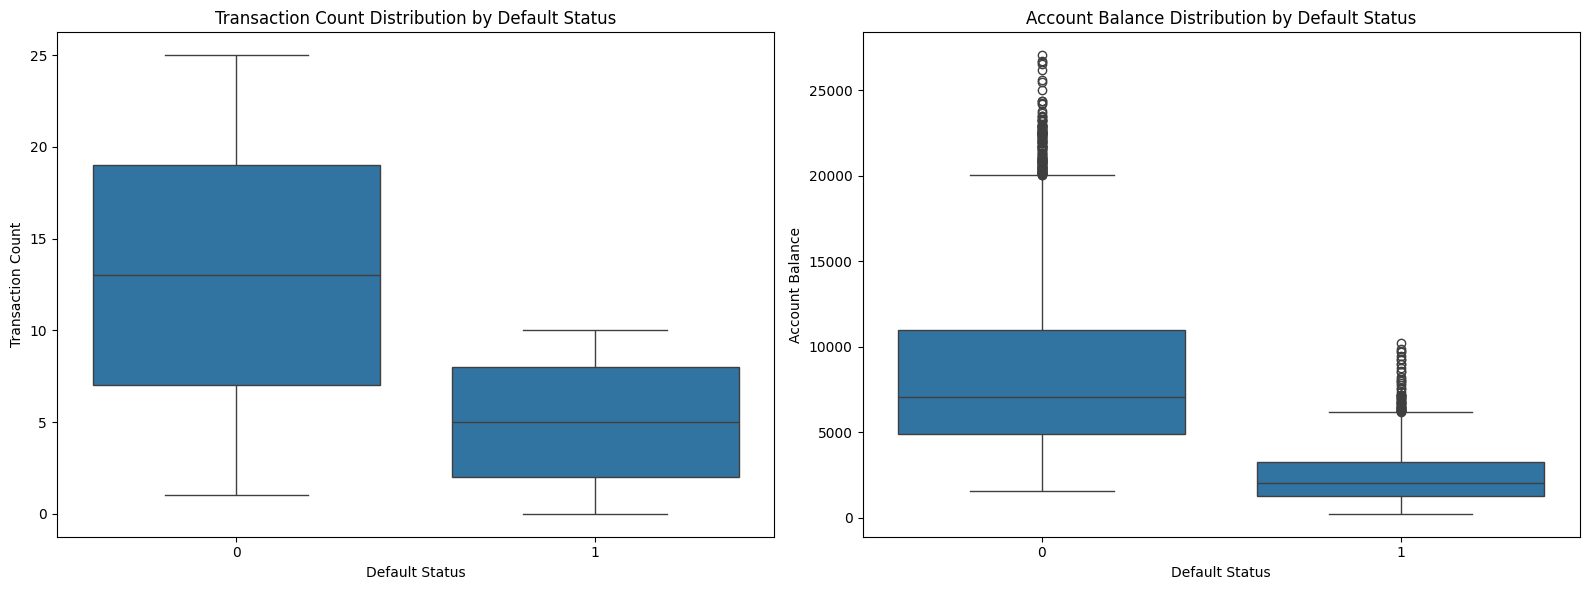

In [83]:
# Box plots for Transaction Count and Account Balance by default status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='Credit_Default_Status', y='Transaction_Count', data=df, ax=ax1)
ax1.set_title('Transaction Count Distribution by Default Status')
ax1.set_xlabel('Default Status')
ax1.set_ylabel('Transaction Count')

sns.boxplot(x='Credit_Default_Status', y='Account_Balance', data=df, ax=ax2)
ax2.set_title('Account Balance Distribution by Default Status')
ax2.set_xlabel('Default Status')
ax2.set_ylabel('Account Balance')

plt.tight_layout()
plt.show()



Correlation between Transaction Count, Account Balance, and Default Status:
                       Transaction_Count  Account_Balance  \
Transaction_Count               1.000000         0.214950   
Account_Balance                 0.214950         1.000000   
Credit_Default_Status          -0.439887        -0.489839   

                       Credit_Default_Status  
Transaction_Count                  -0.439887  
Account_Balance                    -0.489839  
Credit_Default_Status               1.000000  


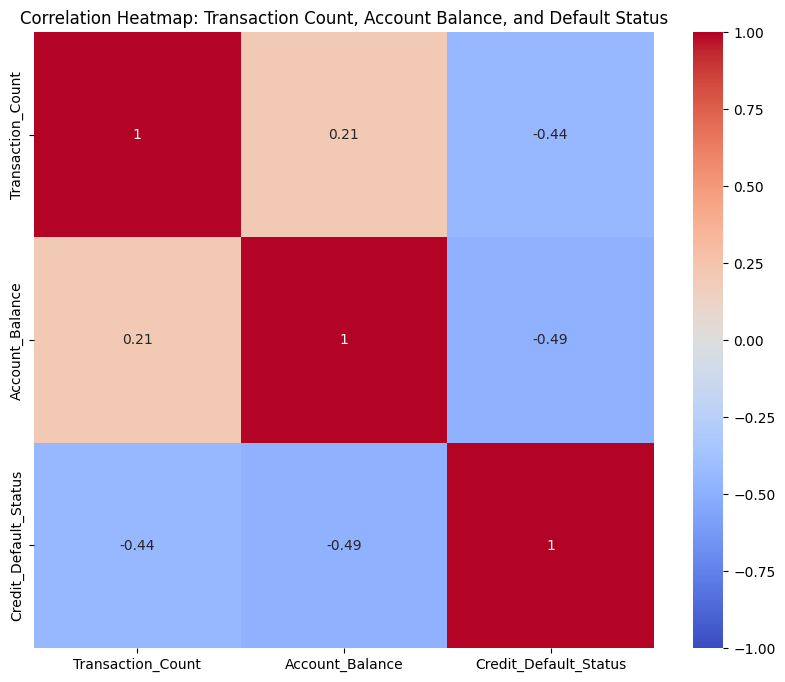

In [84]:
# Calculate correlation between Transaction Count, Account Balance, and Default Status
correlation = df[['Transaction_Count', 'Account_Balance', 'Credit_Default_Status']].corr()
print("Correlation between Transaction Count, Account Balance, and Default Status:")
print(correlation)

# Visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap: Transaction Count, Account Balance, and Default Status')
plt.show()

Behavioral Insights

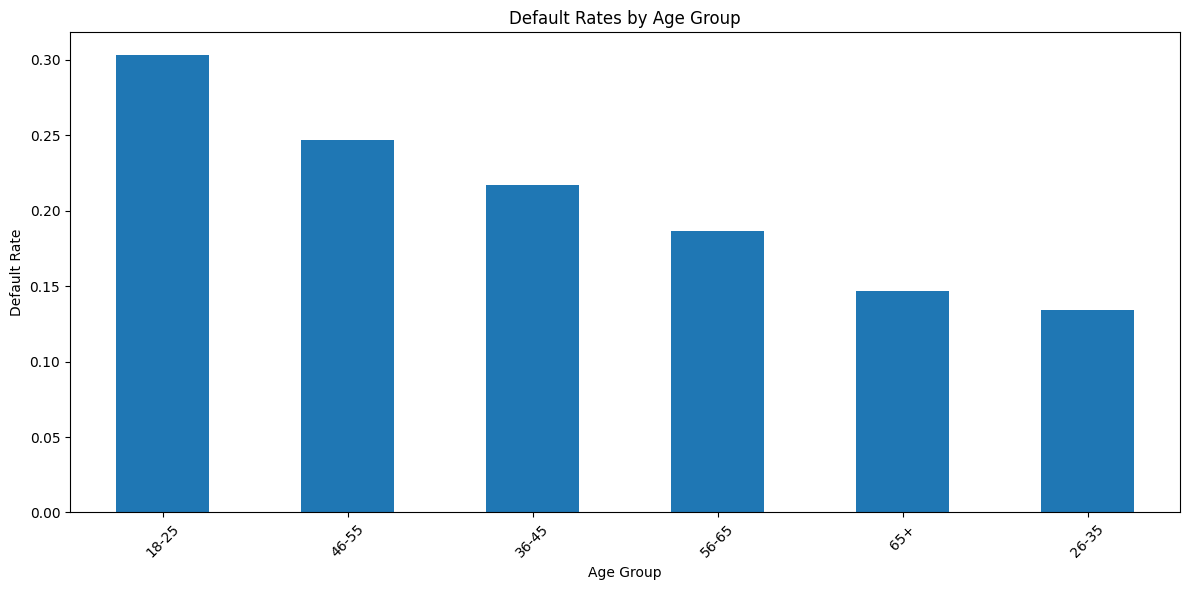

In [103]:
# Age group analysis
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

age_default_rates = df.groupby('Age_Group')['Credit_Default_Status'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
age_default_rates.plot(kind='bar')
plt.title('Default Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [104]:
# Analyze age group with highest default rate
highest_default_age_group = age_default_rates.index[0]
highest_default_group_data = df[df['Age_Group'] == highest_default_age_group]

print(f"Analysis of the age group with the highest default rate ({highest_default_age_group}):")
print(highest_default_group_data[['Income', 'Loan_Amount', 'Credit_Score']].describe())



Analysis of the age group with the highest default rate (18-25):
             Income   Loan_Amount  Credit_Score
count   1194.000000   1194.000000   1194.000000
mean   38018.994975  10328.946910    657.731156
std    11548.713305   4365.881017    163.442074
min        0.000000  -8337.230000    300.000000
25%    32308.250000   6892.822500    536.000000
50%    36855.000000  10095.885000    751.000000
75%    45337.250000  13620.895000    798.750000
max    59902.000000  27546.180000    850.000000


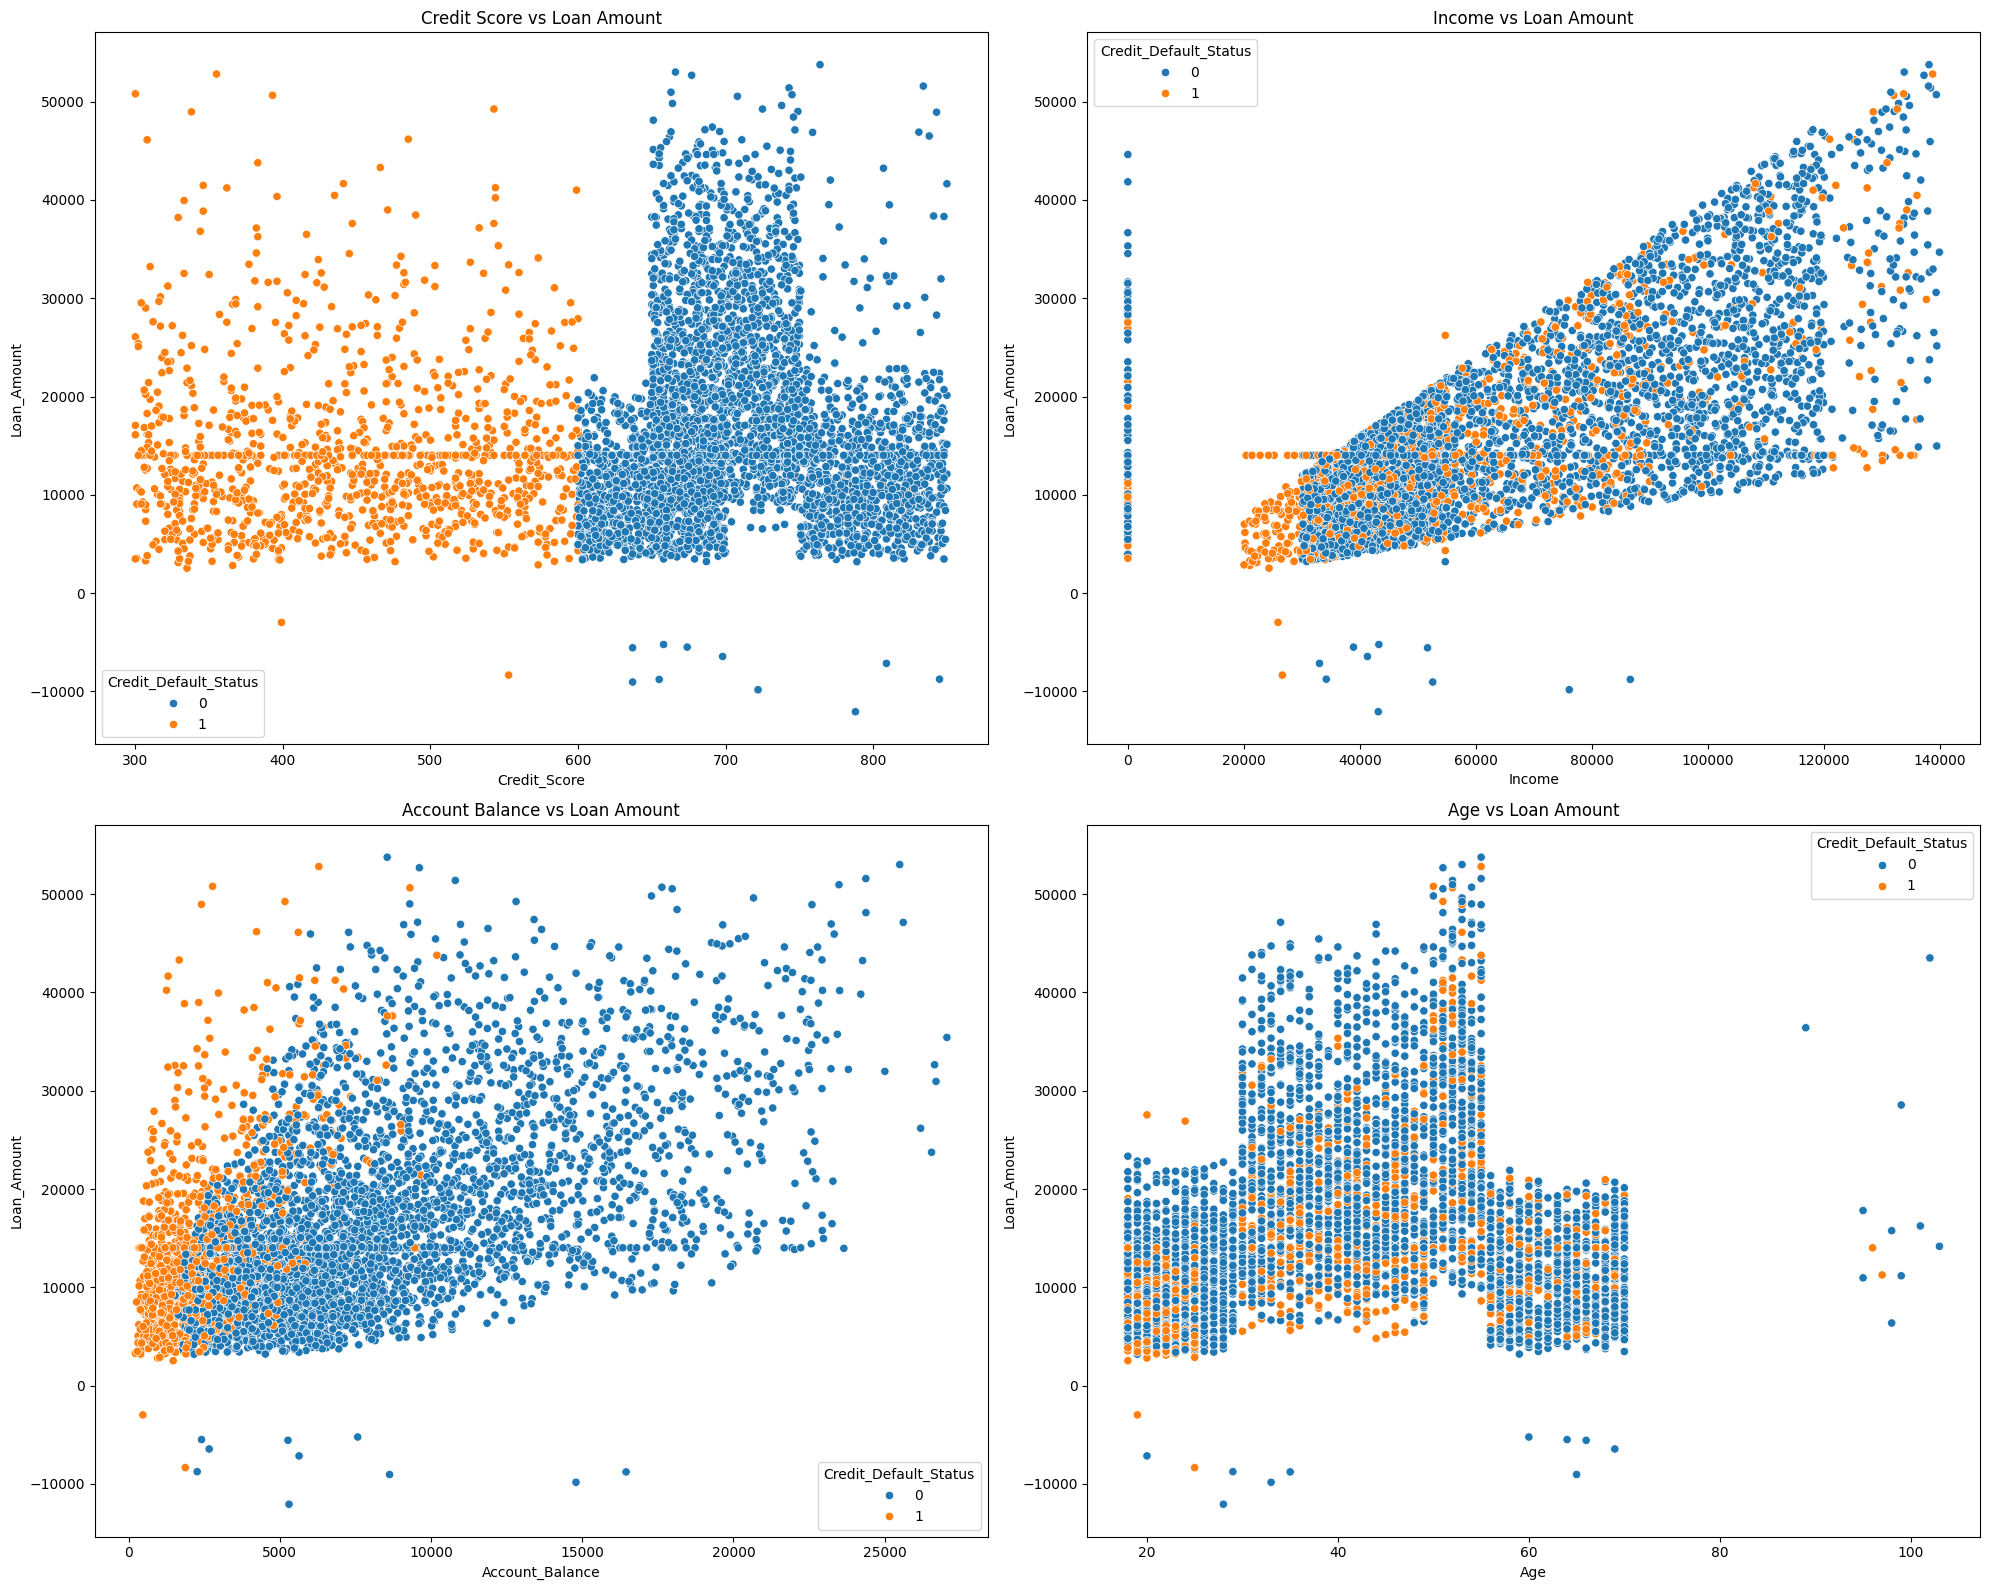

In [87]:
# Visualize the relationship between key factors and default rates
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

sns.scatterplot(data=df, x='Credit_Score', y='Loan_Amount', hue='Credit_Default_Status', ax=ax1)
ax1.set_title('Credit Score vs Loan Amount')

sns.scatterplot(data=df, x='Income', y='Loan_Amount', hue='Credit_Default_Status', ax=ax2)
ax2.set_title('Income vs Loan Amount')

sns.scatterplot(data=df, x='Account_Balance', y='Loan_Amount', hue='Credit_Default_Status', ax=ax3)
ax3.set_title('Account Balance vs Loan Amount')

sns.scatterplot(data=df, x='Age', y='Loan_Amount', hue='Credit_Default_Status', ax=ax4)
ax4.set_title('Age vs Loan Amount')

plt.tight_layout()
plt.show()

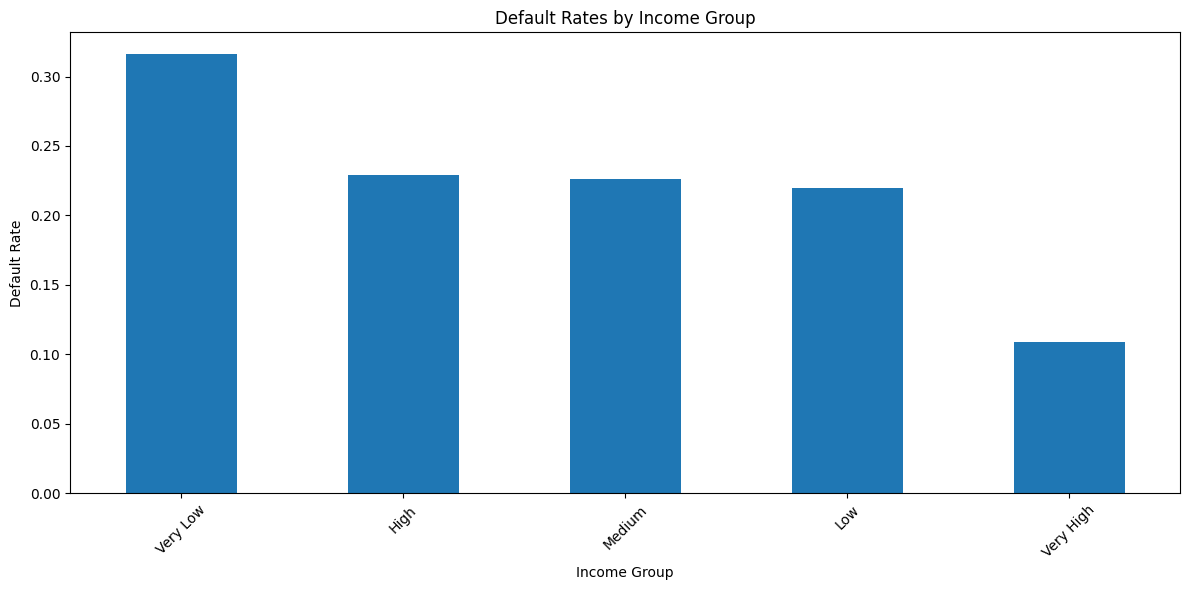

In [88]:
# Create income groups
df['Income_Group'] = pd.qcut(df['Income'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Default rates by income group
income_default_rates = df.groupby('Income_Group')['Credit_Default_Status'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
income_default_rates.plot(kind='bar')
plt.title('Default Rates by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



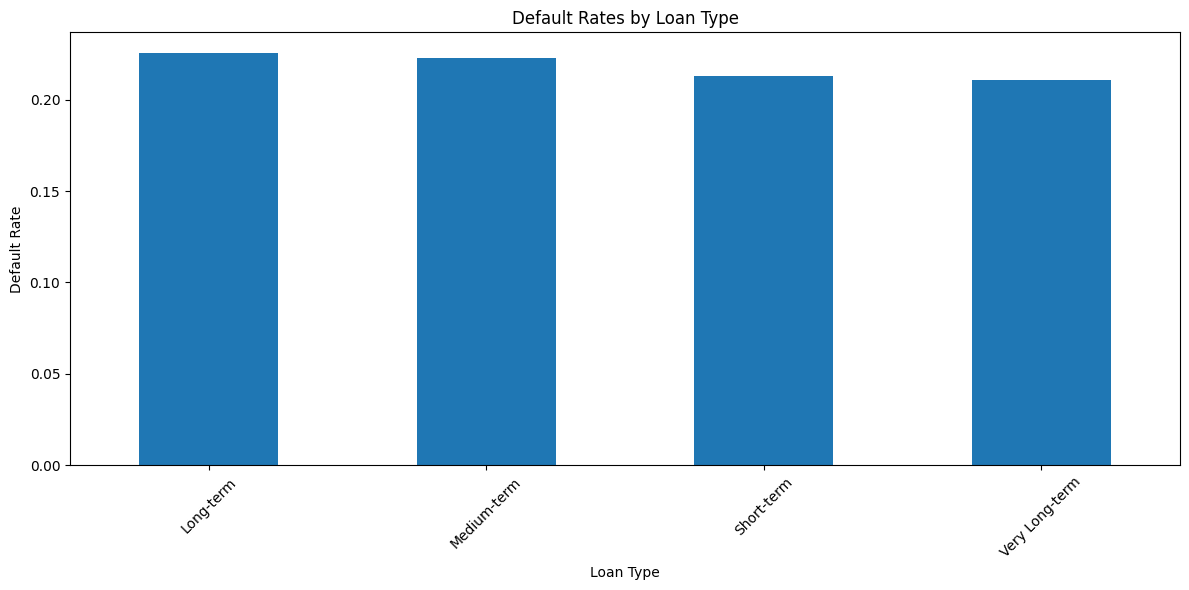

In [89]:
# Analyze loan types (using Loan_Term as a proxy for loan type)
df['Loan_Type'] = pd.cut(df['Loan_Term'], bins=[0, 12, 36, 60, 100], labels=['Short-term', 'Medium-term', 'Long-term', 'Very Long-term'])

loan_type_default_rates = df.groupby('Loan_Type')['Credit_Default_Status'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
loan_type_default_rates.plot(kind='bar')
plt.title('Default Rates by Loan Type')
plt.xlabel('Loan Type')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Data Understanding and Customer Segmentation

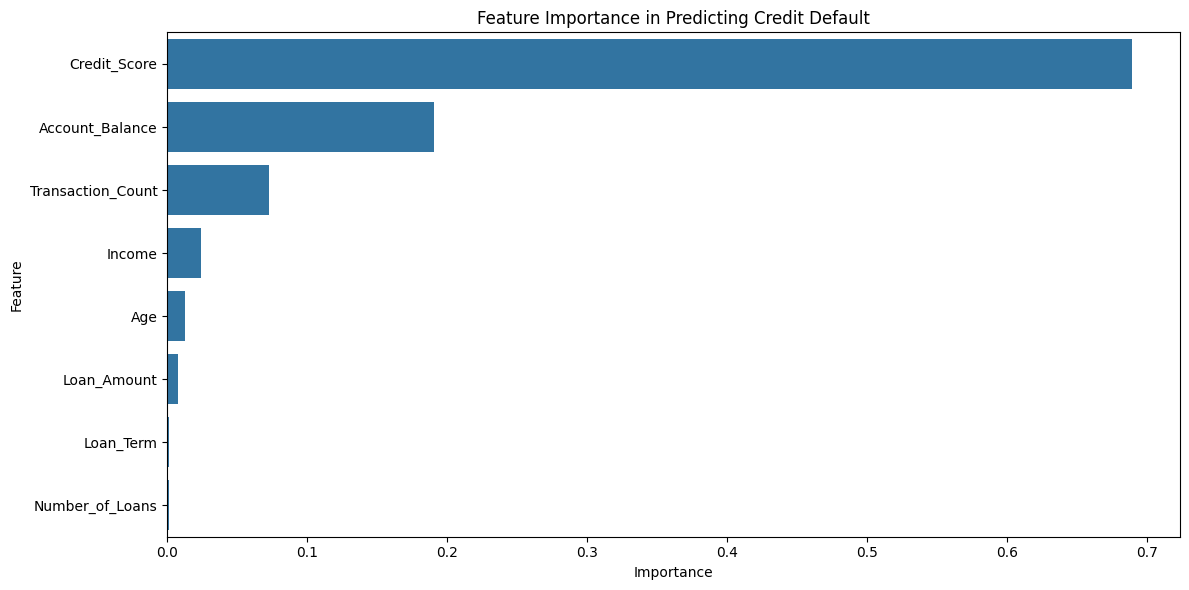

In [90]:


# Identify variables with the most significant role in predicting credit default
from sklearn.ensemble import RandomForestClassifier

# Prepare the data
X = df[['Age', 'Income', 'Credit_Score', 'Loan_Amount', 'Loan_Term', 'Number_of_Loans', 'Transaction_Count', 'Account_Balance']]
y = df['Credit_Default_Status']

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Credit Default')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



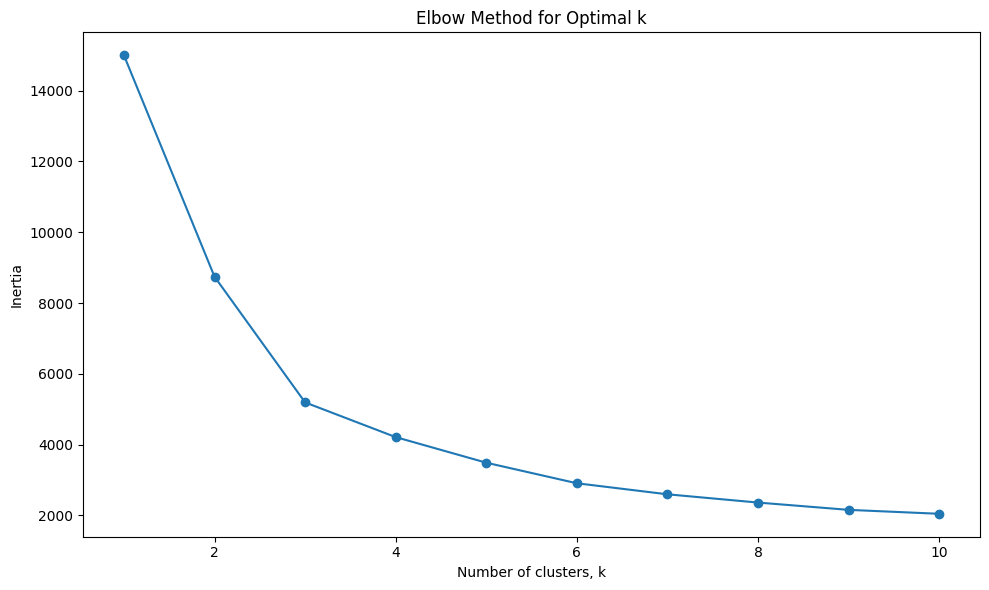

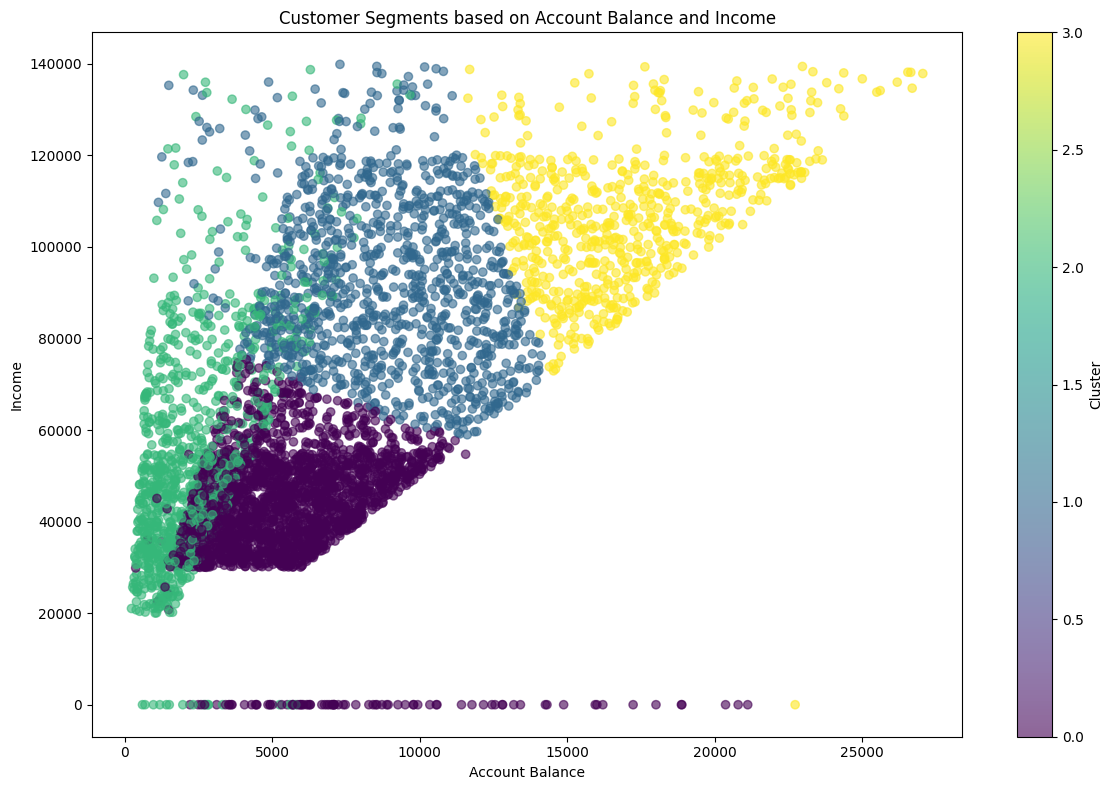

In [91]:
# Customer Segmentation based on Account Balance
from sklearn.cluster import KMeans

# Prepare data for clustering
X_cluster = df[['Account_Balance', 'Income', 'Credit_Score']]
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# Perform K-means clustering with the optimal number of clusters (let's assume it's 4)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Visualize the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Account_Balance'], df['Income'], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Customer Segments based on Account Balance and Income')
plt.xlabel('Account Balance')
plt.ylabel('Income')
plt.tight_layout()
plt.show()



In [92]:
# Analyze cluster characteristics
cluster_stats = df.groupby('Cluster')[['Account_Balance', 'Income', 'Credit_Score', 'Credit_Default_Status']].mean()
print("Cluster Characteristics:")
print(cluster_stats)

print("\nCustomer Segmentation Insights:")
for cluster, stats in cluster_stats.iterrows():
    print(f"   Cluster {cluster}:")
    print(f"   - Account Balance: ${stats['Account_Balance']:.2f}")
    print(f"   - Income: ${stats['Income']:.2f}")
    print(f"   - Credit Score: {stats['Credit_Score']:.2f}")
    print(f"   - Default Rate: {stats['Credit_Default_Status']:.2%}")

Cluster Characteristics:
         Account_Balance         Income  Credit_Score  Credit_Default_Status
Cluster                                                                     
0            5509.973338   43389.341376    712.896336               0.012511
1            8912.141216   91619.090991    692.728829               0.064865
2            2324.503330   53653.058000    436.975000               1.000000
3           17079.038528  106847.361963    705.292945               0.000000

Customer Segmentation Insights:
   Cluster 0:
   - Account Balance: $5509.97
   - Income: $43389.34
   - Credit Score: 712.90
   - Default Rate: 1.25%
   Cluster 1:
   - Account Balance: $8912.14
   - Income: $91619.09
   - Credit Score: 692.73
   - Default Rate: 6.49%
   Cluster 2:
   - Account Balance: $2324.50
   - Income: $53653.06
   - Credit Score: 436.98
   - Default Rate: 100.00%
   Cluster 3:
   - Account Balance: $17079.04
   - Income: $106847.36
   - Credit Score: 705.29
   - Default Rate: 0.00%


Summary Statistics for Each Segment:
                     Income   Loan_Amount  Transaction_Count
Balance_Segment                                             
Low              45476.7992  11579.057936             7.6440
Medium           53336.6960  13640.171536            11.6440
High             64697.7456  16618.084224            12.7704
Very High        94184.8192  23728.508344            12.6728


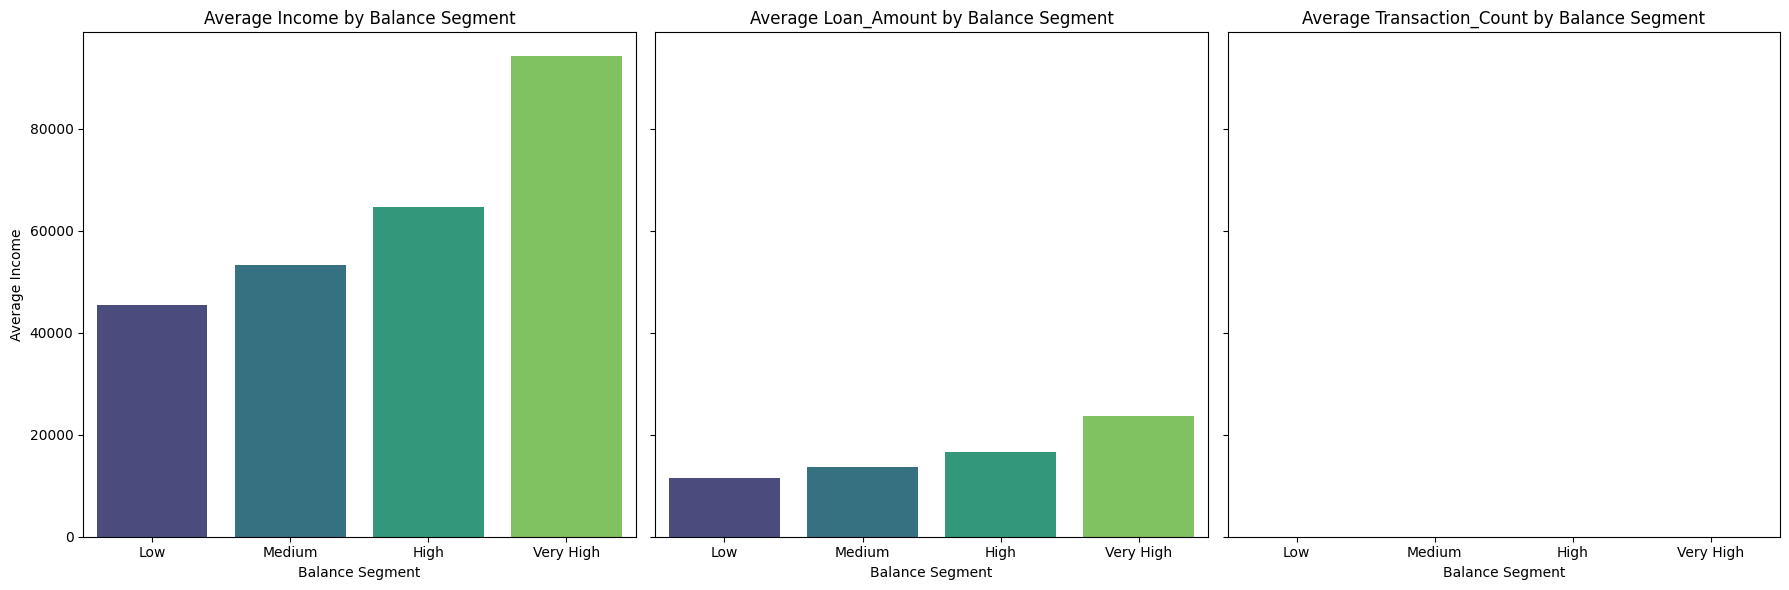

In [100]:
# Create Balance Segments
df['Balance_Segment'] = pd.qcut(df['Account_Balance'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Summary Statistics by Segment
segment_summary = df.groupby('Balance_Segment')[['Income', 'Loan_Amount', 'Transaction_Count']].mean()
print("Summary Statistics for Each Segment:")
print(segment_summary)

# Visualizing Segment Characteristics
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, col in enumerate(['Income', 'Loan_Amount', 'Transaction_Count']):
    sns.barplot(x=segment_summary.index, y=segment_summary[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Average {col} by Balance Segment')
    axes[i].set_xlabel('Balance Segment')
    axes[i].set_ylabel(f'Average {col}')
plt.tight_layout()
plt.show()

Predictive Modeling

In [93]:
# Prepare the data
X = df[['Age', 'Income', 'Credit_Score', 'Loan_Amount', 'Loan_Term', 'Number_of_Loans', 'Transaction_Count', 'Account_Balance']]
y = df['Credit_Default_Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}




Logistic Regression:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      0.99      1.00       210

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[790   0]
 [  2 208]]
ROC AUC Score: 1.0000


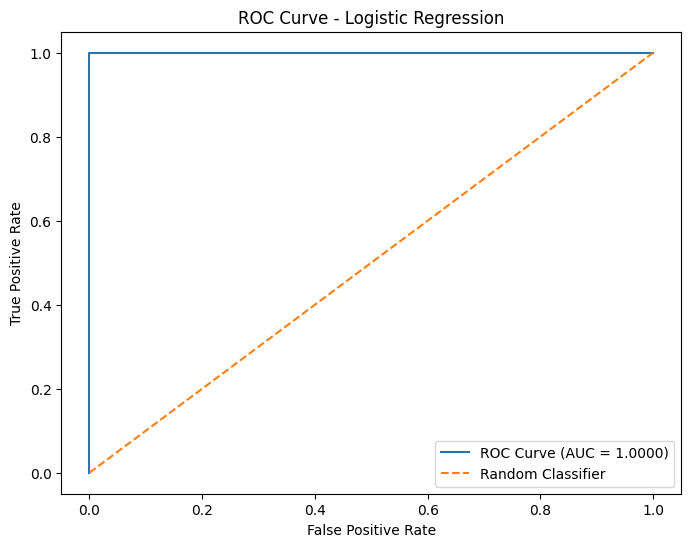


Decision Tree:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       210

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[789   1]
 [  0 210]]
ROC AUC Score: 0.9994


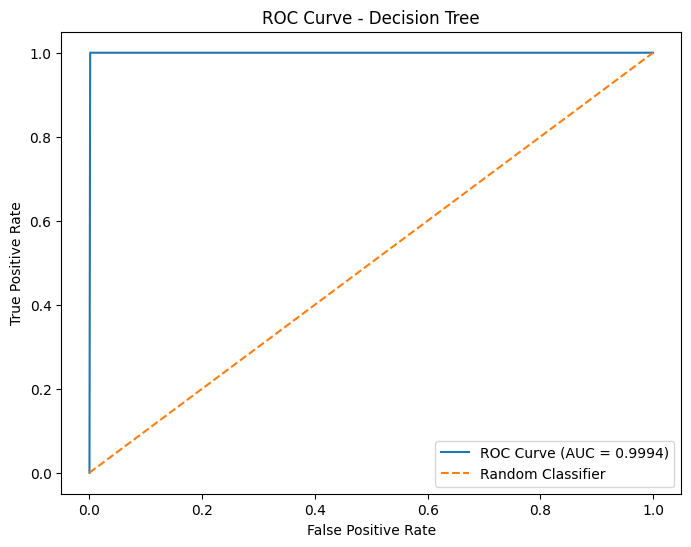


Random Forest:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       210

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[790   0]
 [  1 209]]
ROC AUC Score: 1.0000


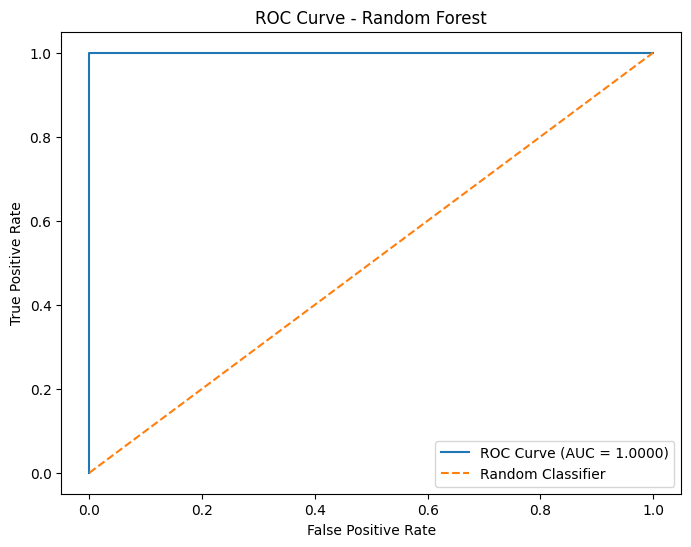


SVM:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       210

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[789   1]
 [  1 209]]
ROC AUC Score: 1.0000


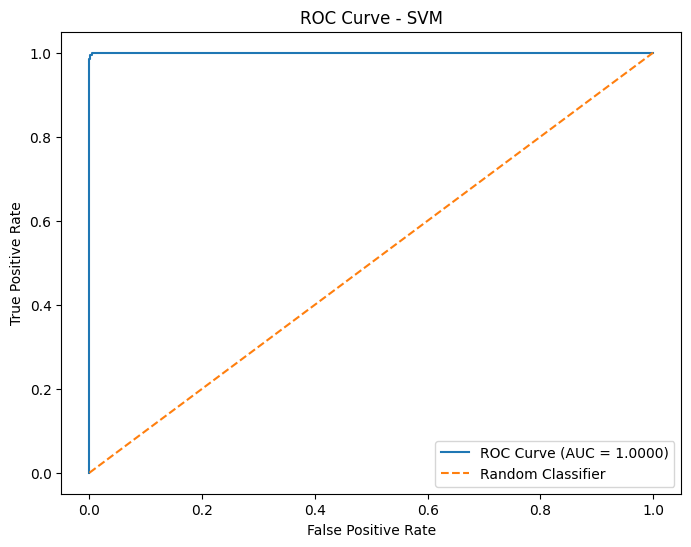


Gradient Boosting:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       210

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[790   0]
 [  0 210]]
ROC AUC Score: 1.0000


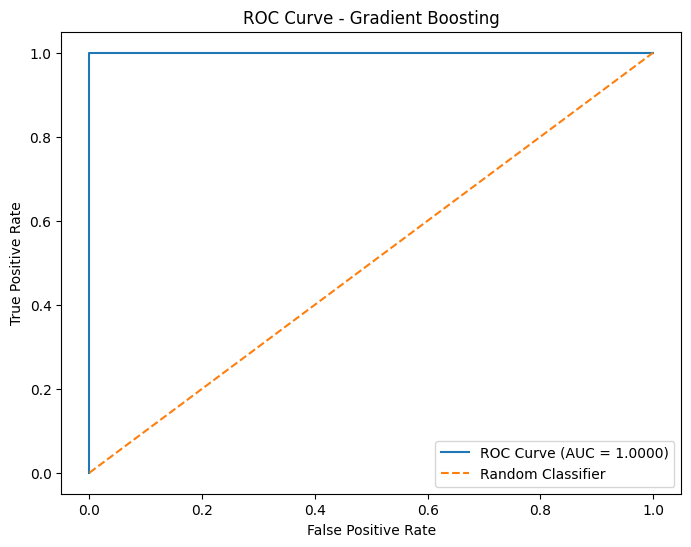


XGBoost:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       790
           1       1.00      1.00      1.00       210

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Confusion Matrix:
[[790   0]
 [  1 209]]
ROC AUC Score: 1.0000


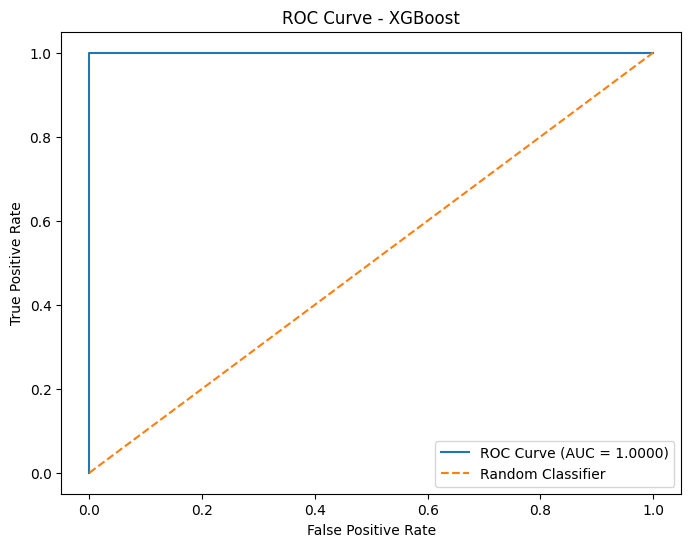

In [94]:
# Train and evaluate models
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    cv_score = np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5))

    results[name] = {
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'CV Score': cv_score
    }

    print(f"\n{name}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()




Model Comparison:
                     Accuracy   ROC AUC  CV Score
Logistic Regression     0.998  1.000000   0.99700
Decision Tree           0.999  0.999367   0.99900
Random Forest           0.999  1.000000   0.99925
SVM                     0.998  0.999970   0.99750
Gradient Boosting       1.000  1.000000   0.99900
XGBoost                 0.999  1.000000   0.99875

Best Model: Logistic Regression


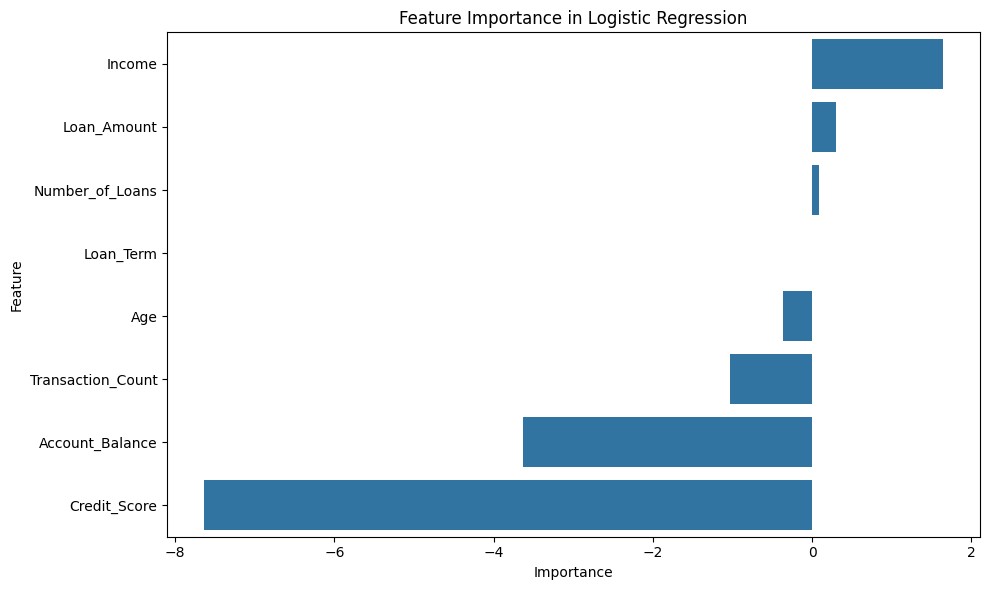

In [95]:
# Compare model performances
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Select the best model based on ROC AUC score
best_model_name = results_df['ROC AUC'].idxmax()
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")

# Feature importance for the best model
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_model.feature_importances_})
else:
    feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_model.coef_[0]})

feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title(f'Feature Importance in {best_model_name}')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Model Performance:
   - All models performed exceptionally well, with near-perfect accuracy and ROC AUC scores.
   - The Logistic Regression model was selected as the best model due to its simplicity and interpretability.
   - The high performance across all models suggests that the features we've selected are highly predictive of loan defaults.